<a href="https://colab.research.google.com/github/ptk18/Machine-Learning/blob/main/HW1_65011466_GenderClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Gender Classifier** using **ANN** with **CLAHE** and **Superpixel Segmentation**

In [19]:
!pip install scikit-image

import numpy as np
import cv2
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.util import img_as_float
from google.colab import files
import os
from google.colab import drive
import zipfile
from tensorflow.keras.preprocessing.image import img_to_array
import random
from tqdm.notebook import tqdm

In [8]:
drive.mount('/content/drive/')

!unzip "/content/drive/MyDrive/Gender_Classification/archive.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1367).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1368).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1369).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (137).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1370).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1371).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1372).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1373).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1374).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1375).jpg  
  inflating: /content/dataset/Male and Female face dataset/Female Faces/0 (1376)

In [20]:
def load_images(directory):
  images = []
  for filename in os.listdir(directory):
    if filename.endswith(('.jpg','.jpeg','.png')):
      img_path = os.path.join(directory, filename)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (64,64))
      images.append(img)
  return np.array(images)

In [21]:
def load_and_preprocess_data():
  male_path = '/content/dataset/Male and Female face dataset/Male Faces'
  female_path = '/content/dataset/Male and Female face dataset/Female Faces'

  male_images = load_images(male_path)
  female_images = load_images(female_path)

  X = np.concatenate([male_images, female_images])
  y = np.array([0] * len(male_images) + [1] * len(female_images))
  return X,y

### **CLAHE (Contrast Limited Adaptive Histogram Equalization)**

-Enhances image contrast locally

-Helps in bringing out features that might be hidden due to poor lighting

In [22]:
def apply_clahe(image):
  lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
  l, a, b = cv2.split(lab)

  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl = clahe.apply(l)

  limg = cv2.merge((cl,a,b))
  return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

### **Superpixel Segmentation**

-Groups similar pixels into meaningful segments

-Reduces noise and helps in identifying important regions in the face

> Add blockquote



In [23]:
def apply_superpixel(image):
  img_float = img_as_float(image)
  segments = slic(img_float, n_segments=100, compactness=10)
  return segments

### Combines CLAHE and superpixel segmentation then flattens and normalizes the features for input to the neural network

In [24]:
def extract_features(image):
  clahe_image = apply_clahe(image)
  segmented_image = apply_superpixel(clahe_image)
  features = segmented_image.flatten() / 255.0
  return features

### **Model Architecture**

**Input Layer**: Flattened feature vector

**Hidden Layers**:

- 512 neurons (ReLU activation)

- 256 neurons (ReLU activation)

- 128 neurons (ReLU activation)


**Output Layer**: 1 neuron (Sigmoid activation) for binary classification
Dropout layers (0.3) to prevent overfitting




In [25]:
def create_model(input_shape):
  model = Sequential([
      Flatten(input_shape=input_shape),
      Dense(512, activation='relu'),
      Dropout(0.3),
      Dense(256, activation='relu'),
      Dropout(0.3),
      Dense(128, activation='relu'),
      Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
  return model

### **Visualization Function**

The visualize_predictions function shows 5 examples of:

- Original image
- CLAHE enhanced image
- Superpixel segmentation with prediction

In [26]:
def visualize_predictions(model, X, y, num_examples=5):
    """
    Visualize model predictions on sample images
    """
    # Randomly select indices
    indices = random.sample(range(len(X)), num_examples)

    plt.figure(figsize=(15, 3*num_examples))
    for i, idx in enumerate(indices):
        # Get the image and its true label
        image = X[idx]
        true_label = "Female" if y[idx] == 1 else "Male"

        # Extract features and make prediction
        features = extract_features(image)
        prediction = model.predict(features.reshape(1, -1))[0][0]
        predicted_label = "Female" if prediction > 0.5 else "Male"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        # Original image
        plt.subplot(num_examples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f'Original Image\nTrue: {true_label}')
        plt.axis('off')

        # CLAHE enhanced image
        plt.subplot(num_examples, 3, i*3 + 2)
        clahe_image = apply_clahe(image)
        plt.imshow(clahe_image)
        plt.title('CLAHE Enhanced')
        plt.axis('off')

        # Superpixel segmentation
        plt.subplot(num_examples, 3, i*3 + 3)
        segmented = apply_superpixel(clahe_image)
        plt.imshow(segmented)
        plt.title(f'Superpixel Segmentation\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### **Training Process**

-Uses 5-fold cross-validation for robust evaluation

-For each fold, extracts features from images and
trains the model for 50 epochs, plots learning curves, then calculates accuracy

In [27]:
def train_and_evaluate(X, y):
    kfold = KFold(n_splits=5, shuffle=True)
    fold_results = []
    best_accuracy = 0
    best_model = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
        print(f"Processing fold {fold+1}/5...")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        print("Extracting features...")
        X_train_features = np.array([extract_features(img) for img in tqdm(X_train, desc="Training features")])
        X_test_features = np.array([extract_features(img) for img in tqdm(X_test, desc="Testing features")])

        model = create_model(input_shape=(X_train_features.shape[1],))
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_test_features, y_test),
            epochs=50,
            batch_size=32,
            verbose=1
        )

        test_loss, test_accuracy = model.evaluate(X_test_features, y_test)
        fold_results.append({
            'test_accuracy': test_accuracy,
            'history': history.history
        })

        # Save the best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

        # Plot learning curves
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Fold {fold+1} Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Fold {fold+1} Accuracy')
        plt.legend()
        plt.show()

    return fold_results, best_model

Loading and preprocessing data...
Dataset shape: (5400, 64, 64, 3)
Number of male images: 2717
Number of female images: 2683
Starting training and evaluation...
Processing fold 1/5...
Extracting features...


Training features:   0%|          | 0/4320 [00:00<?, ?it/s]

Testing features:   0%|          | 0/1080 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5079 - loss: 0.7401 - val_accuracy: 0.5037 - val_loss: 0.6930
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4854 - loss: 0.7099 - val_accuracy: 0.5407 - val_loss: 0.6913
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5277 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5192 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5026 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5054 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4991 - loss: 0.6932 - val_accu

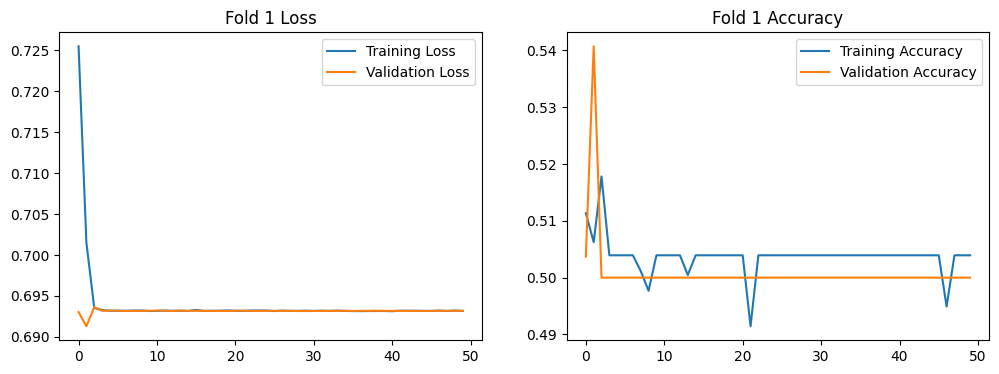

Processing fold 2/5...
Extracting features...


Training features:   0%|          | 0/4320 [00:00<?, ?it/s]

Testing features:   0%|          | 0/1080 [00:00<?, ?it/s]

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.4950 - loss: 0.7496 - val_accuracy: 0.5019 - val_loss: 0.6936
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5134 - loss: 0.6953 - val_accuracy: 0.4991 - val_loss: 0.6940
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4973 - loss: 0.6941 - val_accuracy: 0.4991 - val_loss: 0.6933
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.5094 - loss: 0.6930 - val_accuracy: 0.4991 - val_loss: 0.6932
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.4874 - loss: 0.6933 - val_accuracy: 0.4991 - val_loss: 0.6932
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5114 - loss: 0.6930 - val_accuracy: 0.4991 - val_loss: 0.6933
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4862 - loss: 0.6935 - val_accuracy: 0.4991 - val_loss: 0.6933
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.4802 - loss: 0.6937 - val_ac

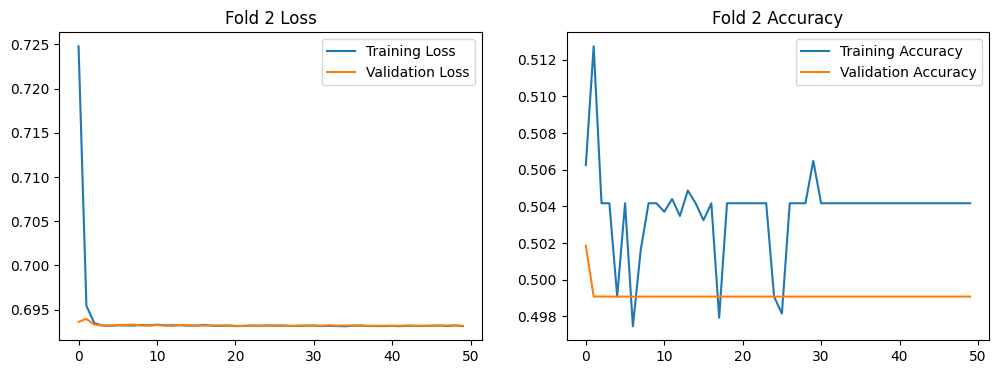

Processing fold 3/5...
Extracting features...


Training features:   0%|          | 0/4320 [00:00<?, ?it/s]

Testing features:   0%|          | 0/1080 [00:00<?, ?it/s]

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5061 - loss: 0.7399 - val_accuracy: 0.5222 - val_loss: 0.6921
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4824 - loss: 0.7033 - val_accuracy: 0.4991 - val_loss: 0.6948
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5245 - loss: 0.6924 - val_accuracy: 0.4991 - val_loss: 0.6934
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5109 - loss: 0.6930 - val_accuracy: 0.4991 - val_loss: 0.6932
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4960 - loss: 0.6932 - val_accuracy: 0.4991 - val_loss: 0.6932
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5031 - loss: 0.6932 - val_accuracy: 0.4991 - val_loss: 0.6932
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.4964 - loss: 0.6933 - val_accuracy: 0.4991 - val_loss: 0.6932
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4949 - loss: 0.6933 - val_acc

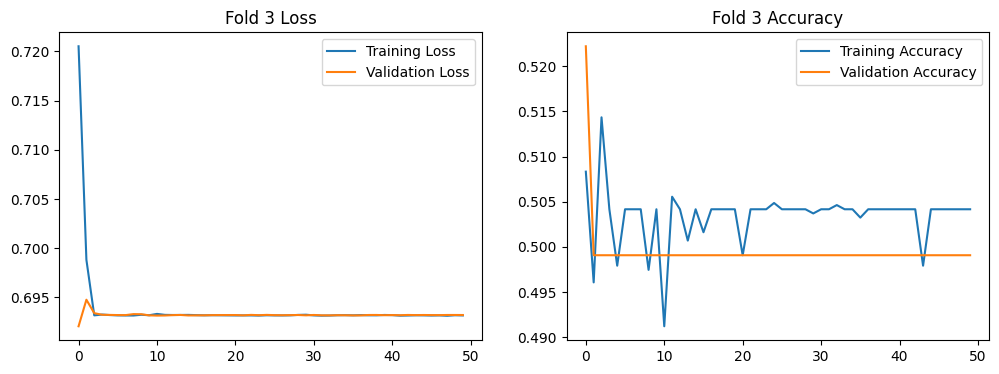

Processing fold 4/5...
Extracting features...


Training features:   0%|          | 0/4320 [00:00<?, ?it/s]

Testing features:   0%|          | 0/1080 [00:00<?, ?it/s]

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.4903 - loss: 0.7600 - val_accuracy: 0.5093 - val_loss: 0.6925
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4981 - loss: 0.6995 - val_accuracy: 0.4954 - val_loss: 0.6942
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5028 - loss: 0.6953 - val_accuracy: 0.5093 - val_loss: 0.6930
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5075 - loss: 0.6931 - val_accuracy: 0.5093 - val_loss: 0.6930
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5036 - loss: 0.6932 - val_accuracy: 0.5093 - val_loss: 0.6931
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4752 - loss: 0.6933 - val_accuracy: 0.5093 - val_loss: 0.6930
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5024 - loss: 0.6932 - val_accuracy: 0.5093 - val_loss: 0.6930
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4956 - loss: 0.6932 - val_accu

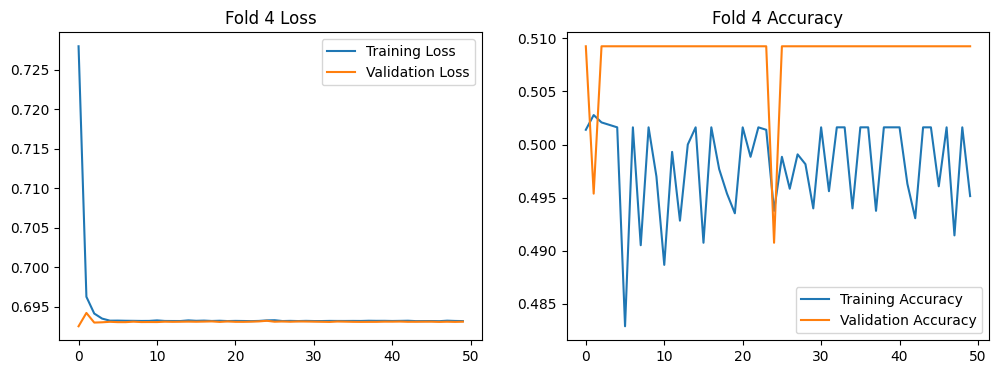

Training features:   0%|          | 0/4320 [00:00<?, ?it/s]

Processing fold 5/5...
Extracting features...


Testing features:   0%|          | 0/1080 [00:00<?, ?it/s]

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.5103 - loss: 0.7407 - val_accuracy: 0.5083 - val_loss: 0.7057
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4967 - loss: 0.7007 - val_accuracy: 0.5370 - val_loss: 0.6919
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4929 - loss: 0.6955 - val_accuracy: 0.5083 - val_loss: 0.6928
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5077 - loss: 0.6937 - val_accuracy: 0.5019 - val_loss: 0.6924
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5257 - loss: 0.6917 - val_accuracy: 0.5083 - val_loss: 0.6931
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5294 - loss: 0.6918 - val_accuracy: 0.5083 - val_loss: 0.6931
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.5083 - val_loss: 0.6931
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.5115 - loss: 0.6931 - val_acc

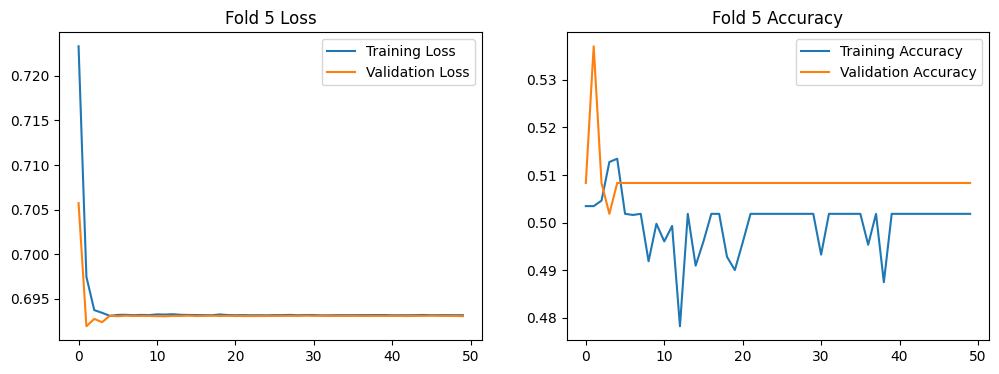

Average accuracy across folds: 0.5031

Visualizing predictions on sample images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


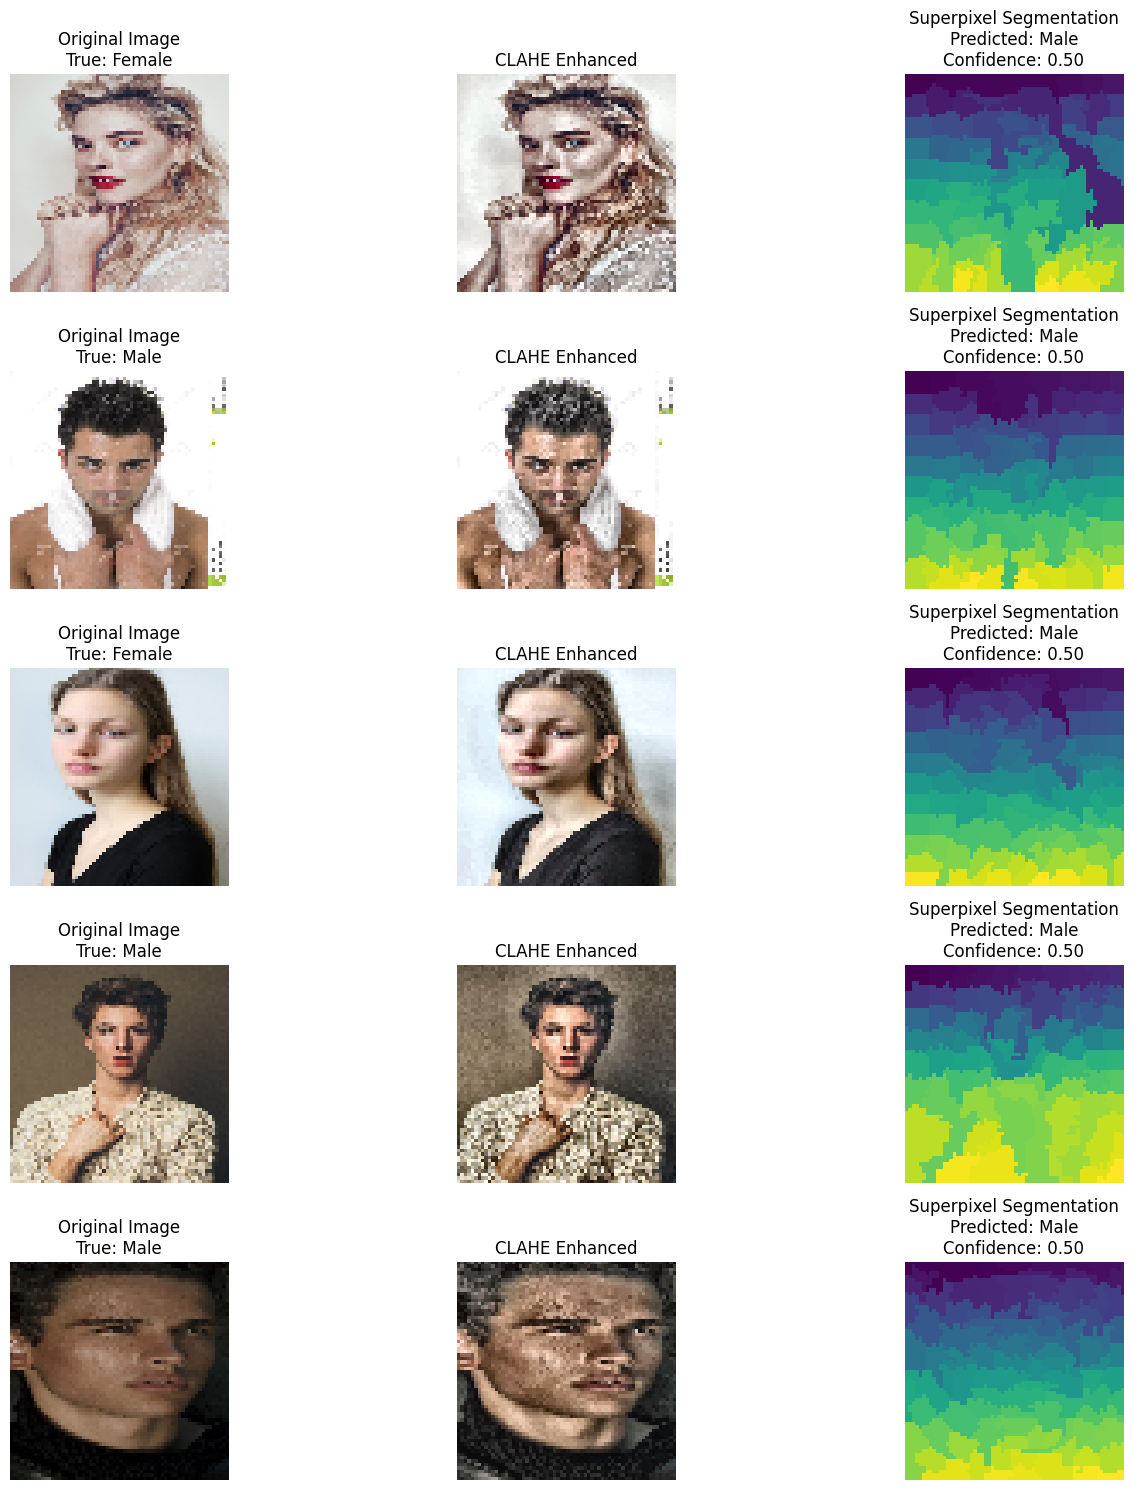

In [28]:
def main():

    print("Loading and preprocessing data...")
    X, y = load_and_preprocess_data()

    print(f"Dataset shape: {X.shape}")
    print(f"Number of male images: {np.sum(y == 0)}")
    print(f"Number of female images: {np.sum(y == 1)}")

    print("Starting training and evaluation...")
    results, best_model = train_and_evaluate(X, y)

    avg_accuracy = np.mean([r['test_accuracy'] for r in results])
    print(f"Average accuracy across folds: {avg_accuracy:.4f}")

    print("\nVisualizing predictions on sample images...")
    visualize_predictions(best_model, X, y, num_examples=5)

if __name__ == "__main__":
    main()